### 100DaysOfMLCodes

### Day_4 (Learn Ensemble Learning and Implementation)

<b style= "font-size: 30px;">ENSEMBLE LEARNING</b>

<img src="ensemble.png" alt="Drawing" style="width: 500px;"/>
Fig. Show Ensemble Modeling

In [1]:
#Libraries for the computation
import pandas as pd
import numpy as np

#libraries for the visualization
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for the data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler

#libraries for the purpose of machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc

from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

In [2]:
%matplotlib inline

In [3]:
plt.style.use('ggplot')

In [4]:
sns.set(style= 'ticks', color_codes= True)

### Predicting Rebublican and Democratic Donations

<b>To illustrate the work of ensemble, I'll use the dataset on U.S. political contribution. It is classification based problem and I've to predict is the donation made by Democratic party or Republic Party, so, I remove all other parties donation from the dataset. Here, I used only important columns that likely useful in prediction.</b>

<b>Source of the dataset: </b> [Political Data U.S.](https://github.com/fivethirtyeight/data/tree/master/science-giving)

In [5]:
#I already preprocessed the data thus I directly read the csv file
data= pd.read_csv('Political dataset/input.csv')

#### About the features
<pre>
<b> 1. entity_tp: tells us whether the prediction was made by an individual (as opposed to an org.)
    2. state: is the state of residence of the contributor
    3. classification: is the scientific field they work in
    4. rpt_tp: this features identifies contributions made during campaigns
    5. tranctional_tp: the from of contribution made, for instance from the candidate himself/herself, or from an      individual to a political committee
    6. cycle: the year of the contibution was made
    7. transction_amt: the nominal USD amount of the donation
    8. cand_pty_affiliation: is the candidate self-reported party affiliation, this is the variable we want to predict
    9. cand_office_st: is the state the candidate is active in
    10. cand_office: is the office they are either occupying or candidating for
    11. cand_status: tells us whether they are candidating for the office or already occupying it
</b>
</pre>

In [6]:
#glimpse of the data
data.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [7]:
data.shape

(100000, 11)

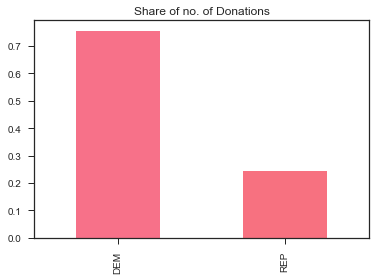

In [38]:
#target feature is cand_pty_affiliation
data['cand_pty_affiliation'].value_counts(normalize= True).plot(kind= 'bar', title= 'Share of no. of Donations')

##### The above diagram showed that the 75% of donation done by the democratic party.

##### For the evaluation matric I used ROC_AUC_SCORE, which trades off having high recall and high precision.

In [9]:
data.dtypes

cand_pty_affiliation     object
cand_office_st           object
cand_office              object
cand_status              object
rpt_tp                   object
transaction_tp           object
entity_tp                object
state                    object
classification           object
cycle                   float64
transaction_amt         float64
dtype: object

In [10]:
#now here I drop target variable from the dataset and for the encoding I used get_dummies() method
y= data['cand_pty_affiliation'].map({'DEM': 1, 'REP': 0})
X= pd.get_dummies(data.drop(['cand_pty_affiliation'],axis= 1), sparse= True)

In [11]:
X.shape, y.shape

((100000, 158), (100000,))

In [12]:
#now here I split the data in training and validation set
#first I set seed
seed= 101
np.random.seed(seed)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.95, random_state= seed)

### What is an Ensemble?
<b> The basic idea behind the ensemble is combining the predictions from the several models averages out or vote out to make overall prediction better.</b><br>
<br>
<b><i>The image below shows the idea behind the ensemble learning</i></b>
<img src="ensemble_network.png" alt="Drawing" style="width: 500px; allign: center"/>

<b> Here, we saw how the ensemble works, it take the predicted result from the individual ml learners and then combine it to make overall result authentics, better, overfitting free, etc.</b>

### Understand Ensembling by combining Decision Trees 

In [13]:
def dt_ensemble(X_train, X_test, y_train, y_test, max_depth, seed= 101):
    roc_score= []
    acc_train= []
    acc_test= []
    for depth in max_depth:
        clf_dt= DecisionTreeClassifier(max_depth= depth, random_state= seed)
        
        #fit the data
        clf_dt.fit(X_train, y_train)
        
        #do prddiction
        prediction= clf_dt.predict(X_test)
        pred_prob= clf_dt.predict_proba(X_test)[::,-1]
        score_roc= roc_auc_score(y_test, pred_prob)
        
        acc_tr= clf_dt.score(X_train, y_train)
        acc_ts= accuracy_score(y_test, prediction)
        
        acc_train.append(acc_tr)
        acc_test.append(acc_ts)
        roc_score.append(score_roc)
      
    df= pd.DataFrame({
        'Max_depth': max_depth,
        'ROC_SCORE': roc_score,
        'Accuracy_train': acc_train,
        'Accuracy_test': acc_test
    })
    #plot the roc_score and max_depth
    plt.plot(df['Max_depth'], df['ROC_SCORE'], lw= 4.0, label= 'ROC_SCORE')
    plt.plot(df['Max_depth'], df['Accuracy_train'], lw= 4.0, label= 'Training Accuracy')
    plt.plot(df['Max_depth'], df['Accuracy_test'], lw= 4.0, label= 'Testing Accuracy')
    plt.title('Accuracy Curve of Decision Tree Classifier')
    plt.legend(loc= 4)
    plt.xlabel('Max_depth')
    plt.ylabel('ROC_SCORE')
    plt.show()
    
    return df

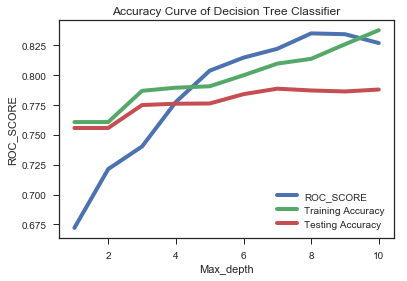

In [14]:
max_depth= list(range(1, 11))
df_result_1= dt_ensemble(X_train, X_test, y_train, y_test, max_depth= max_depth)

In [15]:
df_result_1

,Accuracy_test,Accuracy_train,Max_depth,ROC_SCORE
0,0.755832,0.7608,1,0.672112
1,0.755832,0.7608,2,0.721398
2,0.775063,0.7870,3,0.740334
3,0.776179,0.7896,4,0.777649
4,0.776368,0.7908,5,0.803845
5,0.784179,0.8000,6,0.814804
6,0.788789,0.8098,7,0.822223
7,0.787284,0.8138,8,0.835127
8,0.786442,0.8260,9,0.834441
9,0.788074,0.8378,10,0.827032


#### Variation of decision tree on bagging and boosting

In [49]:
clf_dt= DecisionTreeClassifier(max_depth= 3, random_state= seed)
clf_bag_dt= BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth= 3, random_state= seed),
                              random_state= seed)
clf_boost_dt= AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= 3, random_state= seed),
                                 random_state= seed)

In [51]:
label= ['Clf_Decision_Tree', 'Clf_Bagging_Decision_Tree', 'Clf_Boosting_Decison_Tree']
clf_list= [clf_dt, clf_bag_dt, clf_boost_dt]

result_dt= model_auc(clf_list, X_train, X_test, y_train, y_test, label)

In [52]:
result_dt

,Accuracy,Model
0,0.740334,Clf_Decision_Tree
1,0.775484,Clf_Bagging_Decision_Tree
2,0.863472,Clf_Boosting_Decison_Tree


([<matplotlib.axis.XTick at 0x1bc0a2ddf28>,
 <a list of 3 Text xticklabel objects>)

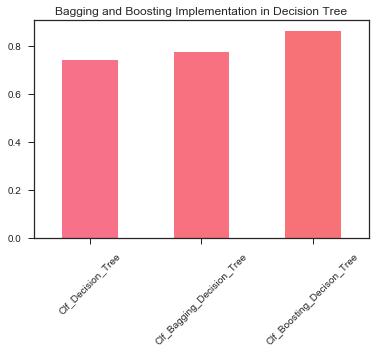

In [54]:
loc= [0,1,2]
result_dt['Accuracy'].plot(kind= 'bar', title= 'Bagging and Boosting Implementation in Decision Tree')
plt.xticks(loc, label, rotation= 45)

##### As you saw the above graph on increasing the no. of tree the complexity also increases, so the best no. of tree in between the less complex model and more complex model, thus I can say where the gap between the training and testing accuracy is less, that is best fit. Thus the best no. max_depth is either 3 or 5.

### KNeighbors Classifier for understanding of ensembles Learning

In [57]:
def knn_ensemble(X_train, X_test, y_train, y_test, neighbors, seed= 101):
    roc_score= []
    acc_train= []
    acc_test= []
    for n in max_depth:
        clf_dt= KNeighborsClassifier(n_neighbors= n)
        
        #fit the data
        clf_dt.fit(X_train, y_train)
        
        #do prddiction
        prediction= clf_dt.predict(X_test)
        pred_prob= clf_dt.predict_proba(X_test)[::,-1]
        score_roc= roc_auc_score(y_test, pred_prob)
        
        acc_tr= clf_dt.score(X_train, y_train)
        acc_ts= accuracy_score(y_test, prediction)
        
        acc_train.append(acc_tr)
        acc_test.append(acc_ts)
        roc_score.append(score_roc)
      
    df= pd.DataFrame({
        'Neighbors': neighbors,
        'ROC_SCORE': roc_score,
        'Accuracy_train': acc_train,
        'Accuracy_test': acc_test
    })
    #plot the roc_score and max_depth
    plt.plot(df['Neighbors'], df['ROC_SCORE'], lw= 4.0, label= 'ROC_SCORE')
    plt.plot(df['Neighbors'], df['Accuracy_train'], lw= 4.0, label= 'Training Accuracy')
    plt.plot(df['Neighbors'], df['Accuracy_test'], lw= 4.0, label= 'Testing Accuracy')
    plt.title('Accuracy Curve of KNeighborsClassifier')
    plt.legend(loc= 4)
    plt.xlabel('n_neighbors')
    plt.ylabel('ROC_SCORE')
    plt.show()
    
    return df

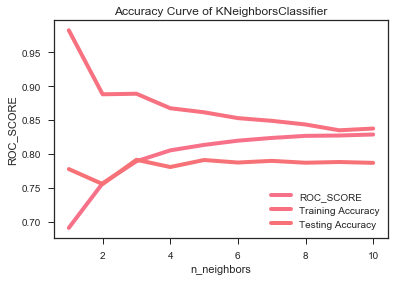

In [58]:
neighbors= range(1, 11)
df_result_knn= knn_ensemble(X_train, X_test, y_train, y_test, neighbors)

In [59]:
df_result_knn

,Accuracy_test,Accuracy_train,Neighbors,ROC_SCORE
0,0.777558,0.9826,1,0.690615
1,0.755379,0.8880,2,0.756508
2,0.791232,0.8888,3,0.789077
3,0.780558,0.8674,4,0.805156
4,0.790926,0.8614,5,0.813229
5,0.787200,0.8528,6,0.819462
6,0.789653,0.8488,7,0.823521
7,0.786895,0.8434,8,0.826587
8,0.787979,0.8348,9,0.827101
9,0.786695,0.8374,10,0.828603


##### As saw the graph and dataframe the best n_neighbors value is 8.

In [60]:
clf_knn= KNeighborsClassifier(n_neighbors= 8)
clf_bag_knn= BaggingClassifier(clf_knn, random_state= seed)
clf_boost_knn= AdaBoostClassifier(clf_knn, random_state= seed, )

In [63]:
label_knn= ['KNeighborsClf', 'KNeighborsClfBag', 'KNeighborsClfBoost']
clf_list_knn= [clf_knn, clf_bag_knn, clf_boost_knn]

df_result_knn_1= model_auc(clf_list_knn, X_train, X_test, y_train, y_test, label_knn)

ValueError: KNeighborsClassifier doesn't support sample_weight.

In [64]:
#now check out different models 
clf_log= LogisticRegression(random_state= seed)
clf_gnb= GaussianNB()
clf_dt= DecisionTreeClassifier(max_depth= 3, random_state= seed)
clf_knn= KNeighborsClassifier(n_neighbors= 8)
clf_nn_mlp= MLPClassifier((80, 100), early_stopping= False, random_state= seed)
clf_rf= RandomForestClassifier(n_estimators= 10, max_features= 3, random_state= seed)
clf_gbc= GradientBoostingClassifier(n_estimators= 100, random_state= seed)

In [65]:
classifier= [clf_log, clf_gnb, clf_dt, clf_knn, clf_nn_mlp, clf_rf, clf_gbc]
name= ['LogisticRegression', 'GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'MLPClassifier', 
       'RandomForestClassifier', 'GradientBoostingClassifier']

In [66]:
def model_auc(classifier, X_train, X_test, y_train, y_test, name):
    acc_roc= []
    #create prediction matrix
    #pred_matrix= np.zeros((y_test.shape[0], len(classifier)))
    #pred_matrix= pd.DataFrame(pred_matrix)
    
    #fitting model
    for model in classifier:
        model.fit(X_train, y_train)
        
        prediction= model.predict_proba(X_test)[::, -1]
        
        score_roc= roc_auc_score(y_test, prediction)
        
        acc_roc.append(score_roc)
        
    #create df 
    df= pd.DataFrame({
        'Model': name,
        'Accuracy': acc_roc
    })
    
    return df

In [67]:
df_result_2= model_auc(classifier, X_train, X_test, y_train, y_test, name)

In [68]:
df_result_2

,Accuracy,Model
0,0.855575,LogisticRegression
1,0.784039,GaussianNB
2,0.740334,DecisionTreeClassifier
3,0.826587,KNeighborsClassifier
4,0.756196,MLPClassifier
5,0.850028,RandomForestClassifier
6,0.876399,GradientBoostingClassifier


##### Here, we saw how the accuracy varied in individual learner and ensemble learner. As you observed the Logistic Regression algorithm works well in sparse matrix than other individual algorithm.

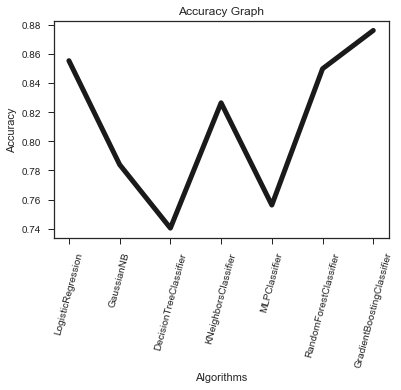

In [69]:
loc= [0,1,2,3,4,5,6]
plt.plot(df_result_2['Accuracy'], 'k-', lw= 5.0)
plt.xticks(loc, name, rotation= 75)
plt.title('Accuracy Graph')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.show()

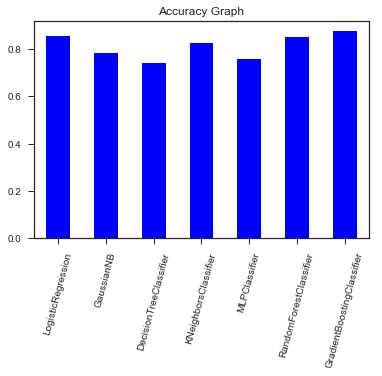

In [70]:
loc= [0, 1, 2, 3, 4, 5, 6]
df_result_2['Accuracy'].plot(kind= 'bar', title= 'Accuracy Graph', color= 'blue')
plt.xticks(loc, name, rotation= 75)
plt.show()

### Correlation Matrix

In [71]:
models= {
    'LogisticRegression': clf_log,
    'GaussianNB': clf_gnb,
    'DecisionTreeClassifier': clf_dt,
    'KNeighborsClassifier': clf_knn,
    'MLPClassifier': clf_nn_mlp,
    'RandomForestClassifier': clf_rf,
    'GradientBoostingClassifier': clf_gbc
}

In [72]:
def train_prediction(model_list, classifier):
    P= np.zeros((y_test[0], len(classifier)))
    P= pd.DataFrame(P)
    cols= list()
    for i, (name, model) in enumerate(model_list.items()):
        model.fit(X_train, y_train)
        
        P.iloc[:, i]= model.predict_proba(X_test)[:,1]
        
        cols.append(name)
        
    P.columns= cols
    
    return P

In [73]:
def score_model(P, y):
    for model in P.columns:
        score= roc_auc_score(y, P.loc[:, model])
        
    return P

In [74]:
trained_models= train_prediction(models, classifier)
result= score_model(trained_models, y_test)

In [75]:
corr= result.corr()

In [76]:
from mlens import visualization

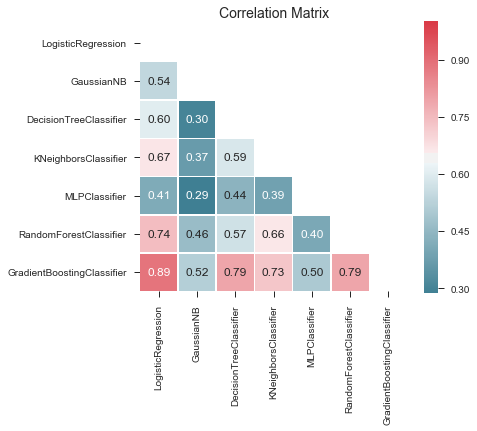

In [77]:
visualization.corrmat(corr, inflate= False, figsize= (6,5))
plt.show()

##### Here, we saw how the accuracy of different model are correlated.

In [78]:
#from the correlation matrix I chose those classifier which have more correlation value more than 0.7
#the models are logisticregression, decisisontreeclassfier, randomforestclassifier, gradientboostingclassifier
#here I fit these in voting classifier
clf_vote= VotingClassifier([('LogisticRegression', clf_log), ('DecisionTreeClassifier', clf_dt),
                            ('RandomForestClassifier', clf_rf), ('GradientBoostingClassifier', clf_gbc),
                            ('KNeighborsClassifier', clf_knn)], voting= 'soft')

#now for stacking classifier I used decisiontreeclf, randomforestclf, gradientboosting clf as base_classifier
#and meta_estimators as clf_log
clf_stack= StackingClassifier([clf_dt, clf_rf, clf_gbc], meta_classifier= clf_log)

#for bagging and boosting I used the logistiregression as base_estimators
clf_bag_log= BaggingClassifier(base_estimator= clf_log, random_state= seed)

clf_boost_log= AdaBoostClassifier(base_estimator= clf_dt, random_state= seed)

In [79]:
classifier_1= [clf_vote, clf_stack, clf_bag_log, clf_boost_log]
name_1= ['VotingClassifier', 'StackingClassifier', 'BaggingClassifier', 'AdaBoostClassifier']

In [80]:
models_1= {
    'VotingClassifier': clf_vote,
    'StackingClassifier': clf_stack,
    'BaggingClassifier': clf_bag_log,
    'AdaBoostClassifier': clf_boost_log
}

In [81]:
df_result_3= model_auc(classifier_1, X_train, X_test, y_train, y_test, name_1)

In [82]:
df_result_3

,Accuracy,Model
0,0.883899,VotingClassifier
1,0.770660,StackingClassifier
2,0.858534,BaggingClassifier
3,0.863472,AdaBoostClassifier


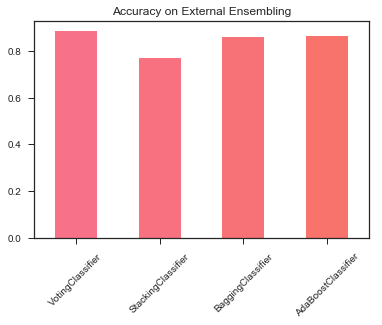

In [86]:
loc= [0,1,2,3]
df_result_3['Accuracy'].plot(kind= 'bar', title= 'Accuracy on External Ensembling')
plt.xticks(loc, name_1, rotation= 45)
plt.show()

In [83]:
trained_models_1= train_prediction(models_1, classifier_1)
result_1= score_model(trained_models_1, y_test)

In [84]:
result_1.head()

,VotingClassifier,StackingClassifier,BaggingClassifier,AdaBoostClassifier
0,0.873656,0.981875,0.928236,0.522054
1,0.977581,0.981875,0.993717,0.552305
2,0.923594,0.981875,0.903772,0.696251
3,0.878347,0.981875,0.897841,0.518851
4,0.817712,0.981875,0.898262,0.685736


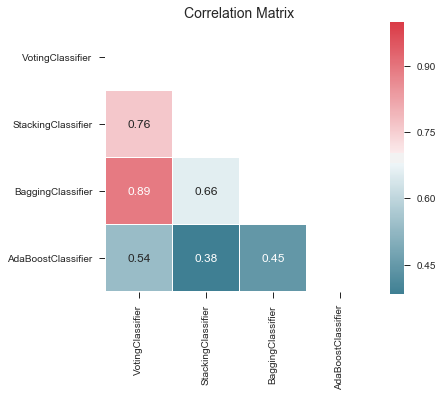

In [85]:
corr_1= result_1.corr()
visualization.corrmat(corr_1, inflate= False, figsize= (6,5))

##### Here, the BaggingClassifier and VotingClassifier is highly correlated and I got the Voting Classifier is best model according to the dataset given

##### That's all about the study of ensemble learning